In [1]:
import sys, os, re, copy, random
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
import isocor

In [9]:
# Degree of 15N enrichment in 15N-amide Gln:
element_prob_dict = {
    'N_natural': 0.00364,
    'N_enriched': 0.997774
}

# List of metabolites labeled by 15N-amide Gln:
metab_to_correct = {
    # AMP = C10H14N5O7P
    # Derived from:
    # 1. Hpx salvage (2x natural abundance N) + 3x natural abundance N (from 2xAsp and Gly)
    # 2. 2x Gln + 3x natural abundance N (from 2xAsp and Gly)
    'AMP pos': {
        'Nmes': 5, # Number of measured isotopologues (excluding m+0), unmeasured isotopologues will be set to zero
        'Niso': 5, # Number of isotope positions (can be extracted from the "ion_formula")
        'ion_formula': 'C10H15N5O7P', # Chemical formula in the ionized state i.e. includig extra proton in positive mode
        'tracer_element': '15N', # Element to perform natural abundance correction on
        'charge': 1 # Charge on ion
    },
    'ATP pos': {
        'Nmes': 5,
        'Niso': 5,
        'ion_formula': 'C10H17N5O13P3',
        'tracer_element': '15N',
        'charge': -1
    },
    # GMP = C10H14N5O8P
    # Derived from:
    # 1. Hpx salvage (2x natural abundance N) + 1x Gln + 2x natural abundance N (from Asp and Gly)
    # 2. 3x Gln + 2x natural abundance N (from Asp and Gly)
    'GMP pos': {
        'Nmes': 5,
        'Niso': 5,
        'ion_formula': 'C10H15N5O8P',
        'tracer_element': '15N',
        'charge': 1
    },
    'GTP pos': {
        'Nmes': 5,
        'Niso': 5,
        'ion_formula': 'C10H17N5O14P3',
        'tracer_element': '15N',
        'charge': 1
    }
}

In [151]:
def read_data(fnam, fnam_anno, metab_to_correct, sal_ms):
    '''
    Read and assign salvage fraction to data using isocor.
    '''
    ### Read measurements
    ### Replace all N/F with 0 before start ###
    esheet_dict_mes = pd.read_excel(fnam, sheet_name=None)
    annotation_df = pd.read_excel(fnam_anno)
    metab_dict_mes = dict()
    metab_names_mes = list()
    for k in esheet_dict_mes.keys():
        if 'U-13C' not in k:
            metab_names_mes.append(k)
            metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
            metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
            # Add annotations:
            metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
            metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'ISTD Response', 'Flag Details'], axis=1)

    # Transfer to single dataframe:
    df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
    for nam in metab_names_mes:
        assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
        df[nam] = metab_dict_mes[nam]['Response']

    # Perform natural abundance correction using isocor #
    tracer_purity = {'15N': [1-element_prob_dict['N_enriched'], element_prob_dict['N_enriched']]}
    for metab in metab_to_correct.keys():
        # Initiate corrector object:
        ion_formula = metab_to_correct[metab]['ion_formula']
        charge = metab_to_correct[metab]['charge']
        tracer_element = metab_to_correct[metab]['tracer_element']
        metab_name, polarity = metab.split()
        Nmes1 = metab_to_correct[metab]['Nmes']+1
        corrector_HR = isocor.mscorrectors.MetaboliteCorrectorFactory(formula=ion_formula, label=metab_name, tracer=tracer_element, tracer_purity=tracer_purity[tracer_element], resolution=240000, mz_of_resolution=200, charge=charge, correct_NA_tracer=True, resolution_formula_code='orbitrap')

        # Extract the natural abundance corrected ratios:
        ratios = {'{} 15N{} ratio'.format(metab_name, i):[] for i in range(Nmes1)}
        for sample_idx in range(len(df)):
            obs_mid = list() # observed isotope distribution
            for i in range(metab_to_correct[metab]['Niso']+1):
                if i == 0:
                    obs_mid.append(df['{} {}'.format(metab_name, polarity)].values[sample_idx])
                elif i <= metab_to_correct[metab]['Nmes']:
                    obs_mid.append(df['{} 15N{} {}'.format(metab_name, i, polarity)].values[sample_idx])
                else: # Set isotope abundance to zero if not measured
                    obs_mid.append(0)
            # Calculate the corrected isotope fraction:
            corrected_area, iso_fraction, res, m_enr = corrector_HR.correct(obs_mid)
            iso_fraction_norm = iso_fraction[0:Nmes1] / sum(iso_fraction[0:Nmes1])
            for i in range(Nmes1):
                ratios['{} 15N{} ratio'.format(metab_name, i)].append(iso_fraction_norm[i])
        # Add corrected ratios to dataframe:
        for colname in ratios.keys():
            df[colname] = ratios[colname]
    
    # Find the salvage fraction.
    # NOTE: this depend on the salvaged metabolite.
    sal_data = dict()
    for base in ['AMP', 'ATP', 'GMP', 'GTP']:
        if base[0] == 'A':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values*100,
            1: df['{} 15N1 ratio'.format(base)].values*100,
            2: df['{} 15N2 ratio'.format(base)].values*100,
            3: df['{} 15N3 ratio'.format(base)].values*100,
            4: df['{} 15N4 ratio'.format(base)].values*100,
            5: df['{} 15N5 ratio'.format(base)].values*100
            }
            # Save imputed salvage fraction:
            # m+0 = salvage, m+2 (and m+3, m+4) = de novo synthesis
            denom = copy.deepcopy(obs_data[0])
            for di in range (1, 5):
                denom += obs_data[di]
            nume = copy.deepcopy(obs_data[sal_ms['G'][0]])
            for mi in sal_ms['A'][1:]:
                nume += obs_data[mi]
            sal_data[base] = nume / denom

        if base[0] == 'G':
            obs_data = {
            0: df['{} 15N0 ratio'.format(base)].values*100,
            1: df['{} 15N1 ratio'.format(base)].values*100,
            2: df['{} 15N2 ratio'.format(base)].values*100,
            3: df['{} 15N3 ratio'.format(base)].values*100,
            4: df['{} 15N4 ratio'.format(base)].values*100,
            5: df['{} 15N5 ratio'.format(base)].values*100
            }
            # Save imputed salvage fraction:
            # m+1 = salvage, m+3 (and m+4) = de novo synthesis
            denom = copy.deepcopy(obs_data[0])
            for di in range (1, 5):
                denom += obs_data[di]
            nume = copy.deepcopy(obs_data[sal_ms['G'][0]])
            for mi in sal_ms['G'][1:]:
                nume += obs_data[mi]
            sal_data[base] = nume / denom

    # Collect salvage data and flatten it:
    sal_data['Conc'] = df['Conc'].values
    sal_data['Salvage_metabolite'] = df['Salvage_metabolite'].values
    df_imputed = pd.DataFrame(sal_data)
    df_imputed_flat = pd.melt(df_imputed, id_vars=['Conc', 'Salvage_metabolite'])
    df_imputed_flat = df_imputed_flat.rename(columns={'variable': 'Nucleotide', 'value': 'Salvage fraction'})
    # df_imputed_flat['Type'] = ['Adeno' if base[0] == 'A' else 'Guano' for base in df_imputed_flat['Nucleotide']]
    df_imputed_flat['Nucleotide'] = ['AMP/ATP' if base[0] == 'A' else 'GMP/GTP' for base in df_imputed_flat['Nucleotide']]
    df_imputed_flat['Charge'] = ['Monophosphate' if base[1] == 'M' else 'Triphosphate' for base in df_imputed_flat['Nucleotide']]
    return(df, df_imputed_flat)

### Run natural isotope correction and calculate salvage fraction

In [152]:
# Define the isotopologues that indicate salvage:
sal_ms = {
    'A': [0],
    'G': [0, 1]
}
# Process the dataset:
df_isotopes_H1299, df_H1299 = read_data('input/Vec-Ad-Gu_salvage_H1299.xlsx', 'input/annotations.xlsx', metab_to_correct, sal_ms)
df_isotopes_H1299.to_excel('output/H1299_isotopologues-corrected.xlsx')

### Plot the data

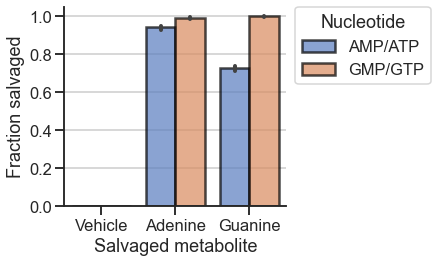

In [154]:
# Plot salvage fraction:
fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4))
g1 = sns.barplot(ax=ax1, data=df_H1299, x='Salvage_metabolite', y='Salvage fraction', hue='Nucleotide', edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set_xlabel('Salvaged metabolite');
g1.set_ylabel('Fraction salvaged');
g1.grid(True, axis='y')
# Add legend:
old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, ncol=1)
sns.despine()
fig.tight_layout()
fig.savefig('output/Vec-Ade-Gua_salvage-fraction.pdf')

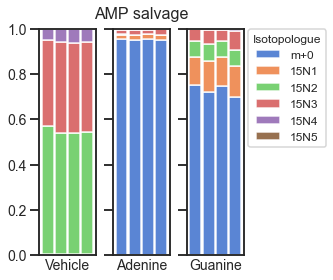

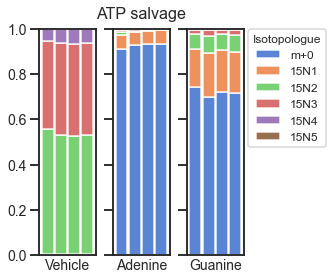

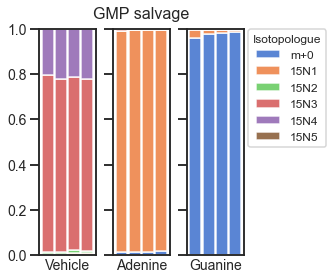

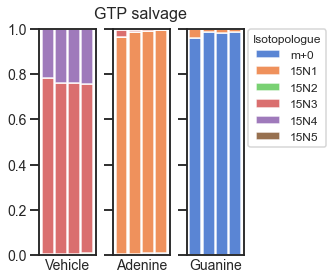

In [122]:
# Loop through each nucleotide:
for nuc in ['AMP', 'ATP', 'GMP', 'GTP']:
    # Plot each condition (Vehicle/Adenine/Guanine):
    fig, axes = plt.subplots(1, 3, figsize=(5, 4), sharey=True)
    sal_metab = ['Vehicle', 'Adenine', 'Guanine']
    for ai, smet in enumerate(sal_metab):
        mask = df_isotopes_H1299['Salvage_metabolite'] == smet
        isotopologues = ['m+0', '15N1', '15N2', '15N3', '15N4', '15N5']
        r = [1, 2, 3, 4] # Replicates
        plot_objs = list()
        bars = [0] * len(df_isotopes_H1299[mask])
        for iso, _ in enumerate(isotopologues):
            bars_next = df_isotopes_H1299[mask]['{} 15N{} ratio'.format(nuc, iso)].values
            p = axes[ai].bar(r, bars_next, edgecolor='white', width=0.9, bottom=bars, alpha=0.9)
            axes[ai].set_xlabel(smet, size=14)
            axes[ai].set_xticks([])
            axes[ai].set_ylim([0, 1])
            axes[ai].tick_params(axis='y', which='major', labelsize=14)
            plot_objs.append(p)
            bars += bars_next
    # Add legend:
    plt.legend([p[1] for p in plot_objs], isotopologues, loc='upper left', bbox_to_anchor=(1.08, 1), borderaxespad=0, fontsize=12, title='Isotopologue', title_fontsize=12);
    fig.text(0.425, 0.95, '{} salvage'.format(nuc), ha='center', size=16)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.3)
    # Save:
    fig.savefig('output/{}-dist.pdf'.format(nuc))